# Object Recognition

In [ ]:
import kagglehub
import shutil
import os
import cv2
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Prepare Dataset

In [ ]:
DATA_PATH = kagglehub.dataset_download("samuelayman/object-detection")

batches = ["Batch 1", "Batch 2", "Batch 3", "Batch 4"]
splits = ["train", "val", "test"]

dataset_dir = "yolo_dataset"
if(os.path.exists(dataset_dir)):
  print("Existed")
else:
  image_dir = os.path.join(dataset_dir, "image")
  label_dir = os.path.join(dataset_dir, "label")

  os.makedirs(image_dir, exist_ok=True)
  os.makedirs(label_dir, exist_ok=True)

  for batch in batches:
    batch_path = os.path.join(DATA_PATH, "final batches", batch)

    for split in splits:
      img_src = os.path.join(batch_path, "images", split)
      lbl_src = os.path.join(batch_path, "labels", split)

      if not os.path.isdir(img_src): continue

      for f in os.listdir(img_src):
        src = os.path.join(img_src, f)
        dst = os.path.join(image_dir, f)
        shutil.copy(src, dst)

      for f in os.listdir(lbl_src):
        src = os.path.join(lbl_src, f)
        dst = os.path.join(label_dir, f)
        shutil.copy(src, dst)

  print("Merged All Batch")

100%|██████████| 1.40G/1.40G [00:18<00:00, 81.9MB/s]

Extracting files...


Merged All Batch


In [ ]:
CLASS_NAMES = [
    "Person", "Chair", "Toothbrush", "Knife", "Bottle", "Cup", "Spoon",
    "Bench", "Refrigerator", "Fork", "Bus", "Toilet", "Bicycle", "Airplane",
    "Truck", "Motorcycles", "Oven", "Dog", "Bed", "Cat", "Traffic_Light",
    "Currency", "Face", "Stop_Sign", "Car", "Barriers", "Path_Holes",
    "Stairs", "Train", "Bin", "Blind_Stick", "Men_Sign", "Cell Phone",
    "Women_Sign", "Tap"
]
if(os.path.exists("dataset")):
  print("Existed")
else:
  for cname in CLASS_NAMES:
    os.makedirs(os.path.join("dataset", cname), exist_ok=True)

  for label_file in os.listdir(label_dir):
    if not label_file.endswith(".txt"): continue

    label_path = os.path.join(label_dir, label_file)
    img_name = label_file.replace(".txt", ".jpg")
    img_path = os.path.join(image_dir, img_name)

    if not os.path.exists(img_path):
      img_name = label_file.replace(".txt", ".png")
      img_path = os.path.join(image_dir, img_name)
      if not os.path.exists(img_path): continue

    img = cv2.imread(img_path)
    if img is None: continue

    h, w = img.shape[:2]

    with open(label_path, "r") as f:
      lines = f.readlines()

    for idx, line in enumerate(lines):
      parts = line.strip().split()
      if len(parts) < 5: continue

      class_id = int(parts[0])
      class_name = CLASS_NAMES[class_id]

      xc, yc, bw, bh = map(float, parts[1:5])

      x1 = int((xc - bw/2) * w)
      y1 = int((yc - bh/2) * h)
      x2 = int((xc + bw/2) * w)
      y2 = int((yc + bh/2) * h)

      x1 = max(0, x1)
      y1 = max(0, y1)
      x2 = min(w, x2)
      y2 = min(h, y2)

      roi = img[y1:y2, x1:x2]

      if roi.size == 0: continue

      out_name = f"{img_name.replace('.jpg','').replace('.png','')}_{idx}.jpg"
      out_path = os.path.join("dataset", class_name, out_name)
      cv2.imwrite(out_path, roi)

## ACF Feature Extraction

In [ ]:
def compute_gradients(img_gray):
  gx = cv2.Sobel(img_gray, cv2.CV_32F, 1, 0, ksize=1)
  gy = cv2.Sobel(img_gray, cv2.CV_32F, 0, 1, ksize=1)

  mag = np.sqrt(gx * gx + gy * gy)
  ori = (np.arctan2(gy, gx) * 180 / np.pi) % 180

  return mag, ori

In [ ]:
def gradient_histogram(mag, ori, bins=6):
  h, w = mag.shape
  hist = np.zeros((h, w, bins), dtype=np.float32)

  bin_width = 180 // bins
  for b in range(bins):
    mask = (ori >= b * bin_width) & (ori < (b + 1) * bin_width)
    hist[:, :, b] = mag * mask.astype(np.float32)
  return hist

In [ ]:
def aggregate_channel(channel, cell_size=4):
  h, w = channel.shape
  h2, w2 = h // cell_size, w // cell_size
  out = cv2.resize(channel, (w2, h2), interpolation=cv2.INTER_AREA)
  return out

In [ ]:
def acf_features(img, cell_size=4):
  img = cv2.resize(img, (32, 64))
  luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)

  L = luv[:, :, 0]
  U = luv[:, :, 1]
  V = luv[:, :, 2]

  mag, ori = compute_gradients(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
  mag_norm = mag / (mag.max() + 1e-6)
  hist = gradient_histogram(mag_norm, ori)

  channels = []
  for ch in [L, U, V]:
    channels.append(aggregate_channel(ch, cell_size))

  channels.append(aggregate_channel(mag_norm, cell_size))

  for b in range(hist.shape[2]):
    channels.append(aggregate_channel(hist[:, :, b], cell_size))

  feat = np.concatenate([c.flatten() for c in channels])
  return feat

In [ ]:
x = []
y = []

DATASET_ROOT = "dataset/"

print("==== Feature Extraction ====")

for idx, cname in enumerate(CLASS_NAMES):
  images = glob.glob(f"{DATASET_ROOT}/{cname}/*.jpg")
  print(f"[{idx+1}/35] Extracting {cname} [{len(images)} images]...")
  for path in images:
    img = cv2.imread(path)
    feat = acf_features(img)
    x.append(feat)
    y.append(idx)

x = np.array(x)
y = np.array(y)
print(f"==== Total Samples: {len(x)} images ====")

==== Feature Extraction ====
[1/35] Extracting Person [891 images]...
[2/35] Extracting Chair [739 images]...
[3/35] Extracting Toothbrush [686 images]...
[4/35] Extracting Knife [528 images]...
[5/35] Extracting Bottle [628 images]...
[6/35] Extracting Cup [642 images]...
[7/35] Extracting Spoon [543 images]...
[8/35] Extracting Bench [614 images]...
[9/35] Extracting Refrigerator [590 images]...
[10/35] Extracting Fork [601 images]...
[11/35] Extracting Bus [658 images]...
[12/35] Extracting Toilet [580 images]...
[13/35] Extracting Bicycle [597 images]...
[14/35] Extracting Airplane [632 images]...
[15/35] Extracting Truck [586 images]...
[16/35] Extracting Motorcycles [571 images]...
[17/35] Extracting Oven [604 images]...
[18/35] Extracting Dog [720 images]...
[19/35] Extracting Bed [506 images]...
[20/35] Extracting Cat [720 images]...
[21/35] Extracting Traffic_Light [726 images]...
[22/35] Extracting Currency [668 images]...
[23/35] Extracting Face [603 images]...
[24/35] Extra

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print(x_train.shape)

(15319, 1280)


In [ ]:
print(y_train.shape)

(15319,)


## AdaBoost Training

In [ ]:
base = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)
clf = AdaBoostClassifier(
    estimator=base,
    n_estimators=300,
    learning_rate=1.0,
    algorithm="SAMME"
)

print("Training AdaBoost...")
clf.fit(x_scaled, y_train)

Training AdaBoost...


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=5),
                   n_estimators=300)

In [ ]:
print("Mean error:", clf.estimator_errors_.mean())
print("Min error:", clf.estimator_errors_.min())

Mean error: 0.940309860803704
Min error: 0.9066284744336208


## Evaluation

In [ ]:
y_pred = clf.predict(x_test)

print("==== CLASSIFICATION REPORT ====")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

==== CLASSIFICATION REPORT ====
               precision    recall  f1-score   support

       Person       0.00      0.00      0.00       134
        Chair       0.00      0.00      0.00       111
   Toothbrush       0.00      0.00      0.00       103
        Knife       0.00      0.00      0.00        79
       Bottle       0.00      0.00      0.00        94
          Cup       0.00      0.00      0.00        96
        Spoon       0.00      0.00      0.00        82
        Bench       0.00      0.00      0.00        92
 Refrigerator       0.00      0.00      0.00        88
         Fork       0.00      0.00      0.00        90
          Bus       0.00      0.00      0.00        98
       Toilet       0.00      0.00      0.00        87
      Bicycle       0.00      0.00      0.00        90
     Airplane       0.00      0.00      0.00        95
        Truck       0.00      0.00      0.00        88
  Motorcycles       0.00      0.00      0.00        85
         Oven       0.00      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


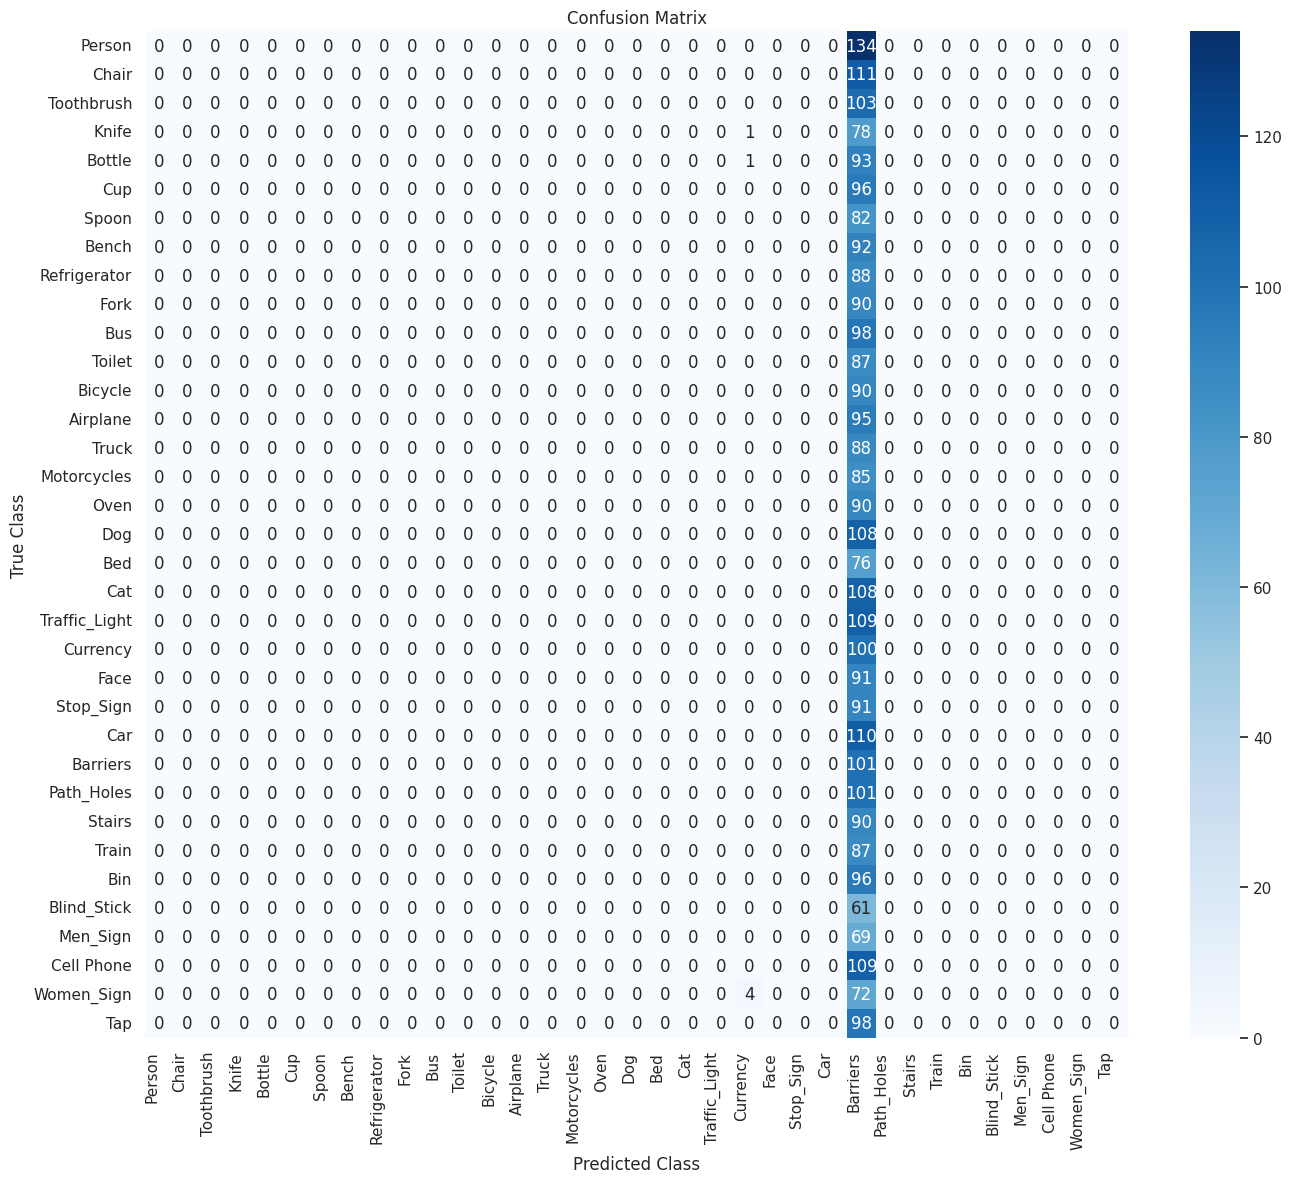

In [ ]:
plt.figure(figsize=(14, 12))
sns.set(font_scale=1.0)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Inference

In [ ]:
def sliding_window(img, step=16, window_size=(64, 128)):
  h, w = img.shape[:2]
  win_w, win_h = window_size

  for y in range(0, h - win_h, step):
    for x in range(0, w - win_w, step):
      yield x, y, img[y:y+win_h, x:x+win_w]

In [ ]:
def detect_acf(img_path, threshold=0.6):
  img = cv2.imread(img_path)
  img_show = img.copy()

  boxes = []
  scores = []
  labels = []

  for x, y, window in sliding_window(img):
    if window.shape[0] != 128 or window.shape[1] != 64: continue
    feat = scaler.transform([acf_features(window)])

    proba = clf.predict_proba(feat)
    prob = proba[0]
    label_id = np.argmax(prob)
    score = prob[label_id]

    if score >= threshold:
      boxes.append([x, y, x+64, y+128])
      scores.append(score)
      labels.append(label_id)

  return img, np.array(boxes), np.array(scores), np.array(labels)

In [ ]:
def nms(boxes, scores, iou_thresh=0.4):
  if len(boxes) == 0: return []

  boxes = boxes.astype(float)
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  idxs = np.argsort(scores)[::-1]
  keep = []

  while len(idxs) > 0:
    i = idxs[0]
    keep.append(i)

    xx1 = np.maximum(x1[i], x1[idxs[1:]])
    yy1 = np.maximum(y1[i], y1[idxs[1:]])
    xx2 = np.minimum(x2[i], x2[idxs[1:]])
    yy2 = np.minimum(y2[i], y2[idxs[1:]])

    inter_w = np.maximum(0, xx2 - xx1)
    inter_h = np.maximum(0, yy2 - yy1)
    inter = inter_w * inter_h

    area_i = (x2[i]-x1[i]) * (y2[i]-y1[i])
    area_j = (x2[idxs[1:]]-x1[idxs[1:]]) * (y2[idxs[1:]]-y1[idxs[1:]])

    iou = inter / (area_i + area_j - inter)

    idxs = idxs[1:][iou < iou_thresh]

  return keep

In [ ]:
def draw_detections(img, boxes, scores, labels):
  out = img.copy()

  for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box
    cls = CLASS_NAMES[label]

    cv2.rectangle(out, (x1,y1), (x2,y2), (0,255,0), 1)
    cv2.putText(out, f"{cls} {score:.2f}", (x1, y1-8), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,0), 1)
  return out

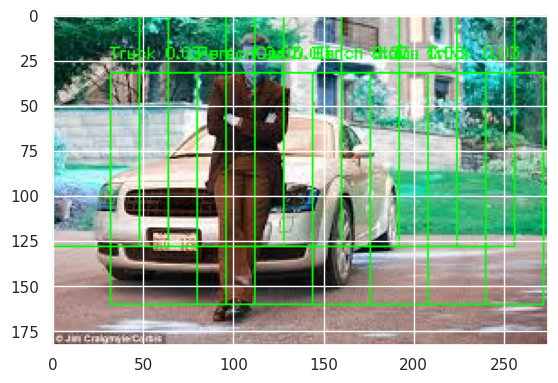

In [ ]:
img, boxes, scores, labels = detect_acf("test.jpg", threshold=0.005)

if len(boxes) == 0:
  print("No objects detected.")
else:
  keep = nms(boxes, scores)
  final_boxes = boxes[keep]
  final_scores = scores[keep]
  final_labels = labels[keep]

  result = draw_detections(img, final_boxes, final_scores, final_labels)
  plt.imshow(result)
  plt.show()

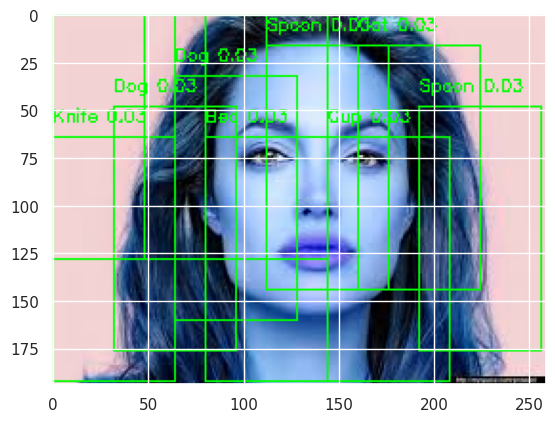

In [ ]:
img, boxes, scores, labels = detect_acf("images.jpg", threshold=0.005)

if len(boxes) == 0:
  print("No objects detected.")
else:
  keep = nms(boxes, scores)
  final_boxes = boxes[keep]
  final_scores = scores[keep]
  final_labels = labels[keep]

  result = draw_detections(img, final_boxes, final_scores, final_labels)
  plt.imshow(result)
  plt.show()